## Async API

In [1]:
import cv2
import time
import numpy as np
import openvino as ov
from IPython import display
import matplotlib.pyplot as plt
import notebook_utils as utils
from pathlib import Path

# directory where model will be downloaded
base_model_dir = "artifacts"

# model name as named in Open Model Zoo
model_name = "person-detection-0202"
precision = "FP16"
model_path = Path("artifacts") / f"{model_name}.xml"

base_model_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1"

if not Path(model_path).exists():
    utils.download_file(f"{base_model_url}/{model_name}/{precision}/{model_name}.xml", filename=model_path.name, directory=model_path.parent)
    utils.download_file(
        f"{base_model_url}/{model_name}/{precision}/{model_name}.bin", filename=model_path.name.replace(".xml", ".bin"), directory=model_path.parent
    )

## Compile the model

In [2]:
import openvino.properties.hint as hints

# initialize OpenVINO runtime
core = ov.Core()
device = "NPU"

# read the network and corresponding weights from file
model = core.read_model(model=model_path)

# compile the model for the CPU (you can choose manually CPU, GPU etc.)
# or let the engine choose the best available device (AUTO)
compiled_model = core.compile_model(model=model, device_name=device, config={hints.performance_mode(): hints.PerformanceMode.THROUGHPUT})

# get input node
input_layer_ir = model.input(0)
N, C, H, W = input_layer_ir.shape
shape = (H, W)

## Create some preprocessing and postprocessing functions

In [3]:
def preprocess(image):
    """
    Define the preprocess function for input data

    :param: image: the orignal input frame
    :returns:
            resized_image: the image processed
    """
    resized_image = cv2.resize(image, shape)
    resized_image = cv2.cvtColor(np.array(resized_image), cv2.COLOR_BGR2RGB)
    resized_image = resized_image.transpose((2, 0, 1))
    resized_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
    return resized_image


def postprocess(result, image, fps):
    """
    Define the postprocess function for output data

    :param: result: the inference results
            image: the orignal input frame
            fps: average throughput calculated for each frame
    :returns:
            image: the image with bounding box and fps message
    """
    detections = result.reshape(-1, 7)
    for i, detection in enumerate(detections):
        _, image_id, confidence, xmin, ymin, xmax, ymax = detection
        if confidence > 0.5:
            xmin = int(max((xmin * image.shape[1]), 10))
            ymin = int(max((ymin * image.shape[0]), 10))
            xmax = int(min((xmax * image.shape[1]), image.shape[1] - 10))
            ymax = int(min((ymax * image.shape[0]), image.shape[0] - 10))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(
                image,
                str(round(fps, 2)) + " fps",
                (5, 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 255, 0),
                3,
            )
    return image

## Get the video

In [4]:
video_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/CEO%20Pat%20Gelsinger%20on%20Leading%20Intel.mp4"
video_path = Path("data/test_video.mp4")
if not video_path.exists():
    utils.download_file(video_url, video_path.name, video_path.parent)

## Sync Mode

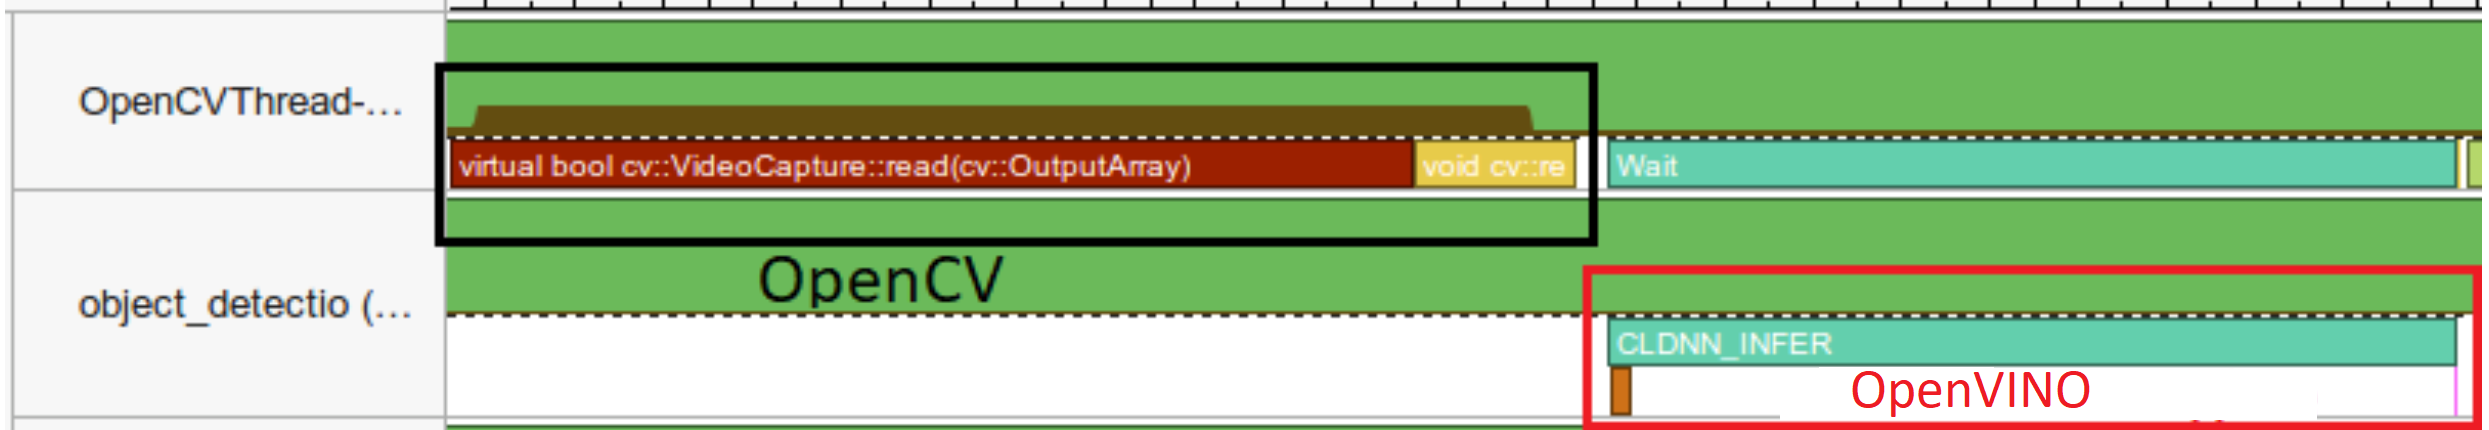

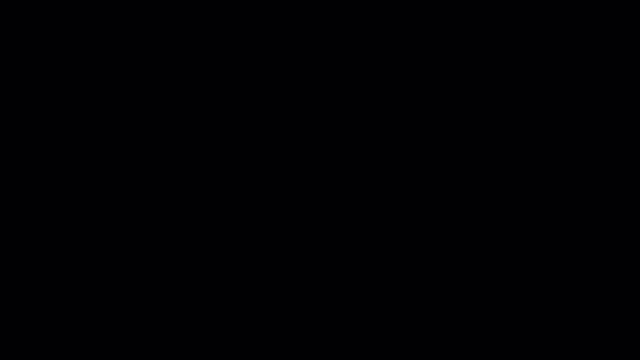

Source ended
average throuput in sync mode: 33.12 fps


In [5]:
def sync_api(source, flip, fps, use_popup, skip_first_frames):
    """
    Define the main function for video processing in sync mode

    :param: source: the video path or the ID of your webcam
    :returns:
            sync_fps: the inference throughput in sync mode
    """
    frame_number = 0
    infer_request = compiled_model.create_infer_request()
    player = None
    try:
        # Create a video player
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        # Start capturing
        start_time = time.time()
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)
        while True:
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            resized_frame = preprocess(frame)
            infer_request.set_tensor(input_layer_ir, ov.Tensor(resized_frame))
            # Start the inference request in synchronous mode
            infer_request.infer()
            res = infer_request.get_output_tensor(0).data
            stop_time = time.time()
            total_time = stop_time - start_time
            frame_number = frame_number + 1
            sync_fps = frame_number / total_time
            frame = postprocess(res, frame, sync_fps)
            # Display the results
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create IPython image
                i = display.Image(data=encoded_img)
                # Display the image in this notebook
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # Any different error
    except RuntimeError as e:
        print(e)
    finally:
        if use_popup:
            cv2.destroyAllWindows()
        if player is not None:
            # stop capturing
            player.stop()
        return sync_fps

sync_fps = sync_api(source=video_path, flip=False, fps=30, use_popup=False, skip_first_frames=800)
print(f"average throuput in sync mode: {sync_fps:.2f} fps")

## Async mode

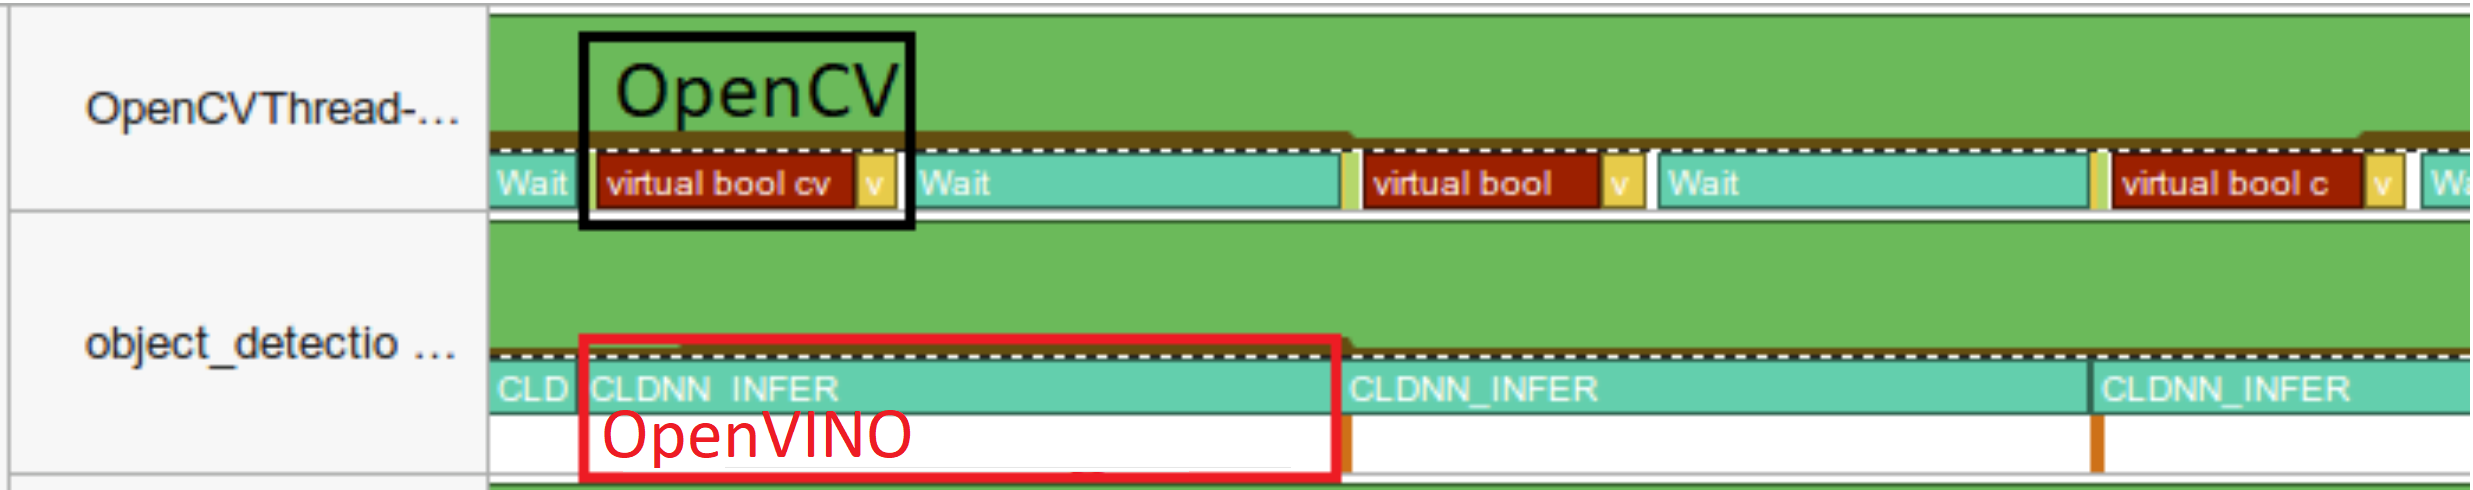

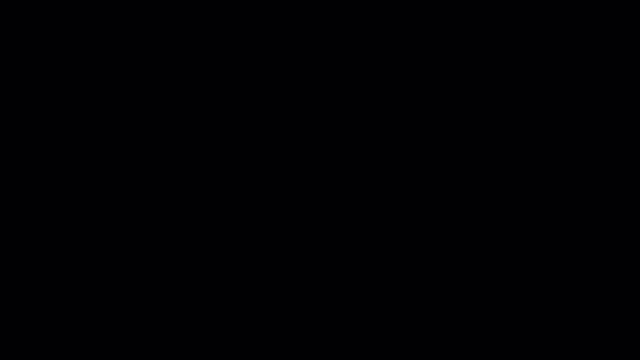

Source ended
average throuput in async mode: 51.91 fps


In [6]:
def async_api(source, flip, fps, use_popup, skip_first_frames):
    """
    Define the main function for video processing in async mode

    :param: source: the video path or the ID of your webcam
    :returns:
            async_fps: the inference throughput in async mode
    """
    frame_number = 0
    # Create 2 infer requests
    curr_request = compiled_model.create_infer_request()
    next_request = compiled_model.create_infer_request()
    player = None
    async_fps = 0
    try:
        # Create a video player
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        # Start capturing
        start_time = time.time()
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)
        # Capture CURRENT frame
        frame = player.next()
        resized_frame = preprocess(frame)
        curr_request.set_tensor(input_layer_ir, ov.Tensor(resized_frame))
        # Start the CURRENT inference request
        curr_request.start_async()
        while True:
            # Capture NEXT frame
            next_frame = player.next()
            if next_frame is None:
                print("Source ended")
                break
            resized_frame = preprocess(next_frame)
            next_request.set_tensor(input_layer_ir, ov.Tensor(resized_frame))
            # Start the NEXT inference request
            next_request.start_async()
            # Waiting for CURRENT inference result
            curr_request.wait()
            res = curr_request.get_output_tensor(0).data
            stop_time = time.time()
            total_time = stop_time - start_time
            frame_number = frame_number + 1
            async_fps = frame_number / total_time
            frame = postprocess(res, frame, async_fps)
            # Display the results
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create IPython image
                i = display.Image(data=encoded_img)
                # Display the image in this notebook
                display.clear_output(wait=True)
                display.display(i)
            # Swap CURRENT and NEXT frames
            frame = next_frame
            # Swap CURRENT and NEXT infer requests
            curr_request, next_request = next_request, curr_request
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # Any different error
    except RuntimeError as e:
        print(e)
    finally:
        if use_popup:
            cv2.destroyAllWindows()
        if player is not None:
            # stop capturing
            player.stop()
        return async_fps

async_fps = async_api(source=video_path, flip=False, fps=30, use_popup=False, skip_first_frames=800)
print(f"average throuput in async mode: {async_fps:.2f} fps")

## Performance comparison

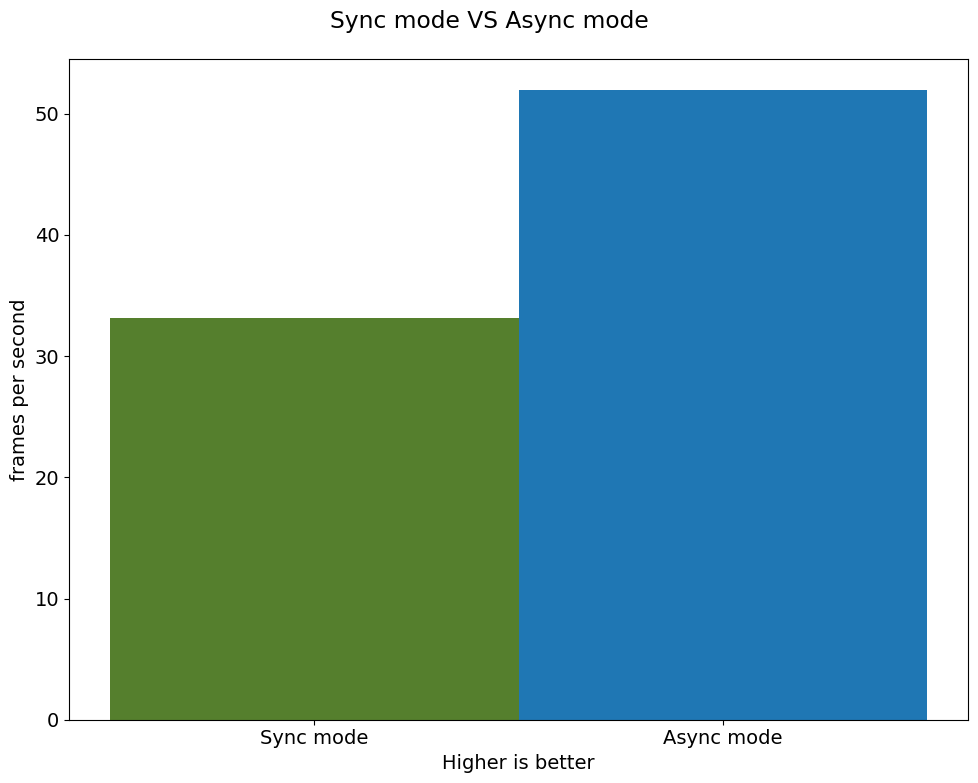

In [7]:
width = 0.4
fontsize = 14

plt.rc("font", size=fontsize)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

rects1 = ax.bar([0], sync_fps, width, color="#557f2d")
rects2 = ax.bar([width], async_fps, width)
ax.set_ylabel("frames per second")
ax.set_xticks([0, width])
ax.set_xticklabels(["Sync mode", "Async mode"])
ax.set_xlabel("Higher is better")

fig.suptitle("Sync mode VS Async mode")
fig.tight_layout()

plt.show()